<a href="https://colab.research.google.com/github/1825050042/20220601/blob/main/cifar_10_kadai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!/usr/local/cuda/bin/nvcc --version # CUDAバージョン確認

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [3]:
import torch
# GPU or CPUの読み込み
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [4]:
# googleColab上で他ファイルのimportを行う
!pip install importnb
import sys
sys.path.append('/content/drive/MyDrive/kadai')
import importnb
with __import__('importnb').Notebook(): 
    import deep_convnet_kadai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from tqdm import tqdm

import torch                # tensorを使用するためのモジュール
import torch.optim as optim # 最適化手法を決定するためのモジュール
from torch import nn        # 深層学習で用いるニューラルネットワークの構成要素が格納
from torch.utils.data import Dataset, DataLoader # オリジナルのデータセットを作成するモジュール
# from torch.autograd import Vatiable # 自動微分用

import torchvision                    # pytorchで画像データを扱うときに使用するモジュール
from torchvision import transforms    # 画像データを変換するモジュール

In [6]:
def unpickle(file): # ファイル読み込み用
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [7]:
# カスタムデータセットを作成する際は、
# Datasetクラスを継承して以下の項目を上書きする。
# ・init() : 初期条件(CSVファイルの読み込み、データの前処理、...)
# ・len() : サンプル数を出力
# ・getitem() : 任意のインデックスでのデータとラベルを出力

# PyTorchではTensor型でデータを取り扱う点に注意。
# Tensor型での画像データの形は以下のように設定する。
# Tensor型 : 4 dimensional shape(batch_size, channels, height, width)
# Tensor型に変換する際にはtorchvisionに存在するToTensor()をするが、
# もともとの画像データは(height, width, channels)である必要がある。
class Cifar10(Dataset):

    def __init__(self, X, y=None, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
    
    def __getitem__(self, index):
        # PyTorch automatically divide image data by 255
        # when its data typy is np.uint8.
        # (np.uint8:unchanged sign value [0 ~ 255])
        img = self.X[index, :] # (height, width, channels)
    
        if self.transform is not None:
            img = self.transform(img)
        
        if self.y is not None: # training
            return img, self.y[index]
        else: # prediction
            return img
    
    def __len__(self):
        return len(self.X)

In [8]:
#!pwd
#%ls
%cd drive/MyDrive/kadai

/content/drive/MyDrive/kadai


In [9]:
# 画像の読み込み
file = ('cifar-10-batches/data_batch_1')
data_batch_1 = unpickle(file)
file = ('cifar-10-batches/data_batch_2')
data_batch_2 = unpickle(file)
file = ('cifar-10-batches/data_batch_5')
data_batch_5 = unpickle(file)
file = ('cifar-10-batches/test_batch')
test_batch = unpickle(file)

print("type(data_batch_1):", type(data_batch_1))
print("data_batch_1.keys():", data_batch_1.keys())

print("type(data_batch_1[b'labels']):", type(data_batch_1[b'labels']))
print("len(data_batch_1[b'labels']):", len(data_batch_1[b'labels']))
print("data_batch_1[b'labels'][:5]:", data_batch_1[b'labels'][:5])

print("type(data_batch_1[b'data']):", type(data_batch_1[b'data']))
print("data_batch_1[b'data'].shape:", data_batch_1[b'data'].shape)
print("data_batch_1[b'data'][:5][:10]:", data_batch_1[b'data'][:5][:10])

print("type(data_batch_1[b'filenames']):", type(data_batch_1[b'filenames']))
print("len(data_batch_1[b'filenames']):", len(data_batch_1[b'filenames']))
print("data_batch_1[b'filenames'][:5]:", data_batch_1[b'filenames'][:5])

type(data_batch_1): <class 'dict'>
data_batch_1.keys(): dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
type(data_batch_1[b'labels']): <class 'list'>
len(data_batch_1[b'labels']): 10000
data_batch_1[b'labels'][:5]: [6, 9, 9, 4, 1]
type(data_batch_1[b'data']): <class 'numpy.ndarray'>
data_batch_1[b'data'].shape: (10000, 3072)
data_batch_1[b'data'][:5][:10]: [[ 59  43  50 ... 140  84  72]
 [154 126 105 ... 139 142 144]
 [255 253 253 ...  83  83  84]
 [ 28  37  38 ...  28  37  46]
 [170 168 177 ...  82  78  80]]
type(data_batch_1[b'filenames']): <class 'list'>
len(data_batch_1[b'filenames']): 10000
data_batch_1[b'filenames'][:5]: [b'leptodactylus_pentadactylus_s_000004.png', b'camion_s_000148.png', b'tipper_truck_s_001250.png', b'american_elk_s_001521.png', b'station_wagon_s_000293.png']


In [10]:
X_data_batch_1 = data_batch_1[b'data']
X_data_batch_2 = data_batch_2[b'data']
X_data_batch_5 = data_batch_5[b'data']
X_data_batch_6 = test_batch[b'data']

y_data_batch_1 = data_batch_1[b'labels']
y_data_batch_2 = data_batch_2[b'labels']
y_data_batch_5 = data_batch_5[b'labels']
y_data_batch_6 = test_batch[b'labels']

# 行方向に画像データを結合
X_train = np.r_['0', X_data_batch_1, X_data_batch_2]
X_valid = X_data_batch_5
X_test = X_data_batch_6
print("X_train.shape:", X_train.shape)
print("X_valid.shape:", X_valid.shape)
print("X_test.shape:", X_test.shape)

X_train.shape: (20000, 3072)
X_valid.shape: (10000, 3072)
X_test.shape: (10000, 3072)


In [11]:
# 上記同様にラベルデータも結合
y_train = np.r_['0', y_data_batch_1, y_data_batch_2]
y_valid = y_data_batch_5
y_test = y_data_batch_6
print("len(y_train):", len(y_train))
print("len(y_valid):", len(y_valid))
print("len(y_test):", len(y_test))

len(y_train): 20000
len(y_valid): 10000
len(y_test): 10000


X_train2.shape: (20000, 3, 32, 32)
X_train3.shape: (20000, 32, 32, 3)


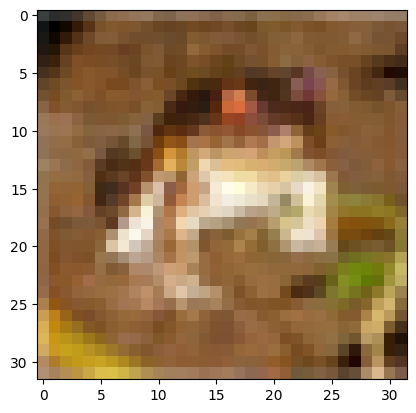

In [12]:
# X_train[:1024]:(赤色情報)
# X_train[1024: 2048]:(緑色情報)
# X_train[2048:](青色情報)
X_train2 = X_train.reshape(-1, 3, 32, 32) # 画像形式に変更
X_train3 = X_train2.transpose((0, 2, 3, 1)) # (N, C, H, W) → (N, H, W, C)
print("X_train2.shape:", X_train2.shape)
print("X_train3.shape:", X_train3.shape)
plt.imshow(X_train3[0])

In [13]:
X_valid2 = X_valid.reshape(-1, 3, 32, 32)
X_valid3 = X_valid2.transpose((0, 2, 3, 1))
X_test2 = X_test.reshape(-1, 3, 32, 32)
X_test3 = X_test2.transpose((0, 2, 3, 1))

In [14]:
# データセットの作成
# PyTorchでのデータセットの作成は、前処理も一緒に処理を行う。
# その際の前処理はtorchvision.transforms.Compose関数を使用して定義する。
# Composeではリストで定義した前処理を定義した順番に適用させていく。（前処理の入力に合わせて型を変える必要がある。）
train_transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=20,fill=0),   #順番注意 
    #transforms.RandomHorizontalFlip(p=0.5)
    transforms.RandomAffine([0,0], scale=(0.8, 1.2))  #0.8縮小1.2拡大

    ])

transform=transforms.Compose([
    transforms.ToTensor()
    ])

train_dataset size: 20000
img.shape: torch.Size([3, 32, 32])
<class 'numpy.int64'>


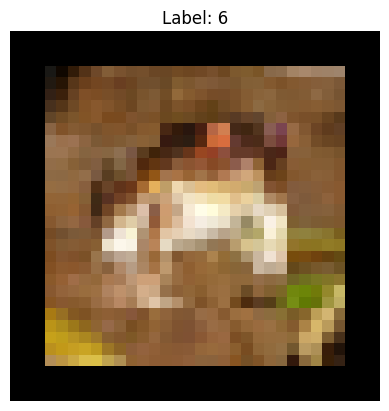

In [15]:
train_dataset = Cifar10(X_train3, y_train, transform=train_transform)
valid_dataset = Cifar10(X_valid3, y_valid, transform=transform)
test_dataset  = Cifar10(X_test3, y_test, transform=transform)
# データセットの中身の確認
print("train_dataset size:", train_dataset.__len__())
img, lab = train_dataset.__getitem__(0) # index=0の画像を出力、ndarray → tensor
print("img.shape:", img.shape)
print(type(lab))

# 画像を表示
plt.imshow(img.permute(1, 2, 0))  # チャンネル次元を最後に移動
plt.title('Label: {}'.format(lab))
plt.axis('off')
plt.show()

In [16]:
# DataLoaderを定義する
# Datasetを渡すことでミニバッチサイズのデータを返すIterableな
# オブジェクトを返してくれる。
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
train_iter = iter(train_loader)
images, labels = next(train_iter)
print("aaa",type(labels))
print('data shape on train loader images : {}'.format(images.size()))
print('data shape on train loader labels : {}'.format(labels.size()))
print('len(train_loader):', len(train_loader)) # train_dataset.__len__() / batch_size

aaa <class 'torch.Tensor'>
data shape on train loader images : torch.Size([128, 3, 32, 32])
data shape on train loader labels : torch.Size([128])
len(train_loader): 157


In [17]:
# 追加モジュール
import torchvision.models as models # 訓練済みの既存モデルを使用するためのモジュール

# モデルの定義
#model = deep_convnet_kadai.DeepSimpleConvNet()
model = deep_convnet_kadai.DeepConvNet()
#model = models.resnet18(pretrained=False) 
#model = models.resnet50(pretrained=False) 
#model.fc = nn.Linear(512, 10)
#model.fc = nn.Linear(2048, 10)
print(model)

DeepConvNet(
  (conv01): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv02): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv03): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv04): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv05): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv06): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3072, out_features=3072, bias=True)
  (fc2): Linear(in_features=3072, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=10, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0

In [18]:
# 損失関数などの定義
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# 学習
mean_train_accuracy = []
mean_valid_accuracy = []
mean_train_losses = []
mean_valid_losses = []
epochs = 20

model.to("cuda:0") # GPUで学習する場合、modelをGPUに転送
device = ("cuda:0")

for epoch in range(epochs):
    model.train() # モデルを学習モードに変更(勾配計算やパラメータ更新を行う)
    
    train_num_per_epoch = 0
    valid_num_per_epoch = 0
    train_correct = 0.0
    valid_correct = 0.0
    train_losses = 0.0
    valid_losses = 0.0
    
    prog_bar = tqdm(train_loader) # 学習時間の可視化
    for i, (images, labels) in enumerate(prog_bar): # ミニバッチサイズ分のデータを順に扱う
        """
        if epoch == 0:
            print("i:", i)
            print("images.shape:", images.shape)
            print("labels.shape:", labels.shape)
        """
        images = images.to(device) # ミニバッチサイズ分の画像データをGPUに転送
        labels = labels.to(device) # ミニバッチサイズ分のラベルデータをGPUに転送
        
        # zero the parameters gradient
        optimizer.zero_grad()
        
        # feedforward -> backward -> optimize
        # forward
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        # backward
        loss.backward()
        # step
        optimizer.step()

        # outputs.shape: torch.Size()[128, 10]
        # outputs[0]: tensor([-1.6166, -0.2910,  0.6484,  0.4901,  0.9068,  0.5496,  0.8523,  0.4417, -1.8475, -0.9370], device='cuda:0', grad_fn=<SelectBackward>)
        _, predicted = torch.max(outputs.data, 1)
        # _.shape: torch.Size([128])
        # _[:10]: tensor([0.9068, 0.7224, 0.7334, 0.5333, 1.1085, 1.4766, 0.9547, 0.7530, 1.4384, 0.3249], device='cuda:0')
        # predicted[:10]: tensor([4, 5, 4, 6, 8, 6, 4, 1, 6, 0], device='cuda:0')
        train_correct += (predicted == labels).sum().item() # 正解数を記録
        train_num_per_epoch += labels.size(0) # 推論した数を記録
        train_losses += loss.item()
        
        
    # 1epoch毎に推論を行う。
    # モデルを推論モードに変更。
    model.eval()
    
    with torch.no_grad():
        for i, (images, labels) in enumerate(valid_loader): # ミニバッチサイズ分のデータを順に扱う
            images = images.to(device)
            labels = labels.to(device)
        
            # feedforward -> loss
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            valid_losses += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            valid_correct += (predicted == labels).sum().item()
            valid_num_per_epoch += labels.size(0)
    
    mean_train_accuracy.append(train_correct / train_num_per_epoch)
    mean_valid_accuracy.append(valid_correct / valid_num_per_epoch)
    mean_train_losses.append(train_losses / len(train_loader))
    mean_valid_losses.append(valid_losses / len(valid_loader))
    
    print('epoch : {}, train loss : {:.4f}, valid loss : {:4f}, train acc : {:.2f}% , valid acc : {:.2f}%' \
          .format(epoch+1, mean_train_losses[-1], mean_valid_losses[-1], 100*mean_train_accuracy[-1], 100*mean_valid_accuracy[-1]))

100%|██████████| 157/157 [00:27<00:00,  5.62it/s]


epoch : 1, train loss : 0.8100, valid loss : 0.881113, train acc : 71.41% , valid acc : 70.25%


100%|██████████| 157/157 [00:24<00:00,  6.49it/s]


epoch : 2, train loss : 0.7932, valid loss : 0.864453, train acc : 72.04% , valid acc : 70.00%


100%|██████████| 157/157 [00:23<00:00,  6.57it/s]


epoch : 3, train loss : 0.7783, valid loss : 0.821390, train acc : 72.69% , valid acc : 71.50%


100%|██████████| 157/157 [00:24<00:00,  6.43it/s]


epoch : 4, train loss : 0.7696, valid loss : 0.840668, train acc : 73.00% , valid acc : 71.16%


100%|██████████| 157/157 [00:23<00:00,  6.62it/s]


epoch : 5, train loss : 0.7394, valid loss : 0.833286, train acc : 74.02% , valid acc : 71.84%


100%|██████████| 157/157 [00:23<00:00,  6.78it/s]


epoch : 6, train loss : 0.7198, valid loss : 0.847458, train acc : 74.66% , valid acc : 71.63%


100%|██████████| 157/157 [00:23<00:00,  6.79it/s]


epoch : 7, train loss : 0.7096, valid loss : 0.818898, train acc : 74.95% , valid acc : 72.11%


100%|██████████| 157/157 [00:25<00:00,  6.24it/s]


epoch : 8, train loss : 0.6889, valid loss : 0.822770, train acc : 75.20% , valid acc : 72.55%


100%|██████████| 157/157 [00:23<00:00,  6.69it/s]


epoch : 9, train loss : 0.6802, valid loss : 0.840213, train acc : 75.91% , valid acc : 71.77%


100%|██████████| 157/157 [00:23<00:00,  6.67it/s]


epoch : 10, train loss : 0.6609, valid loss : 0.838094, train acc : 76.72% , valid acc : 72.36%


100%|██████████| 157/157 [00:23<00:00,  6.74it/s]


epoch : 11, train loss : 0.6547, valid loss : 0.819298, train acc : 76.79% , valid acc : 72.83%


100%|██████████| 157/157 [00:22<00:00,  6.89it/s]


epoch : 12, train loss : 0.6290, valid loss : 0.808827, train acc : 77.53% , valid acc : 73.46%


 96%|█████████▌| 151/157 [00:22<00:00,  6.92it/s]

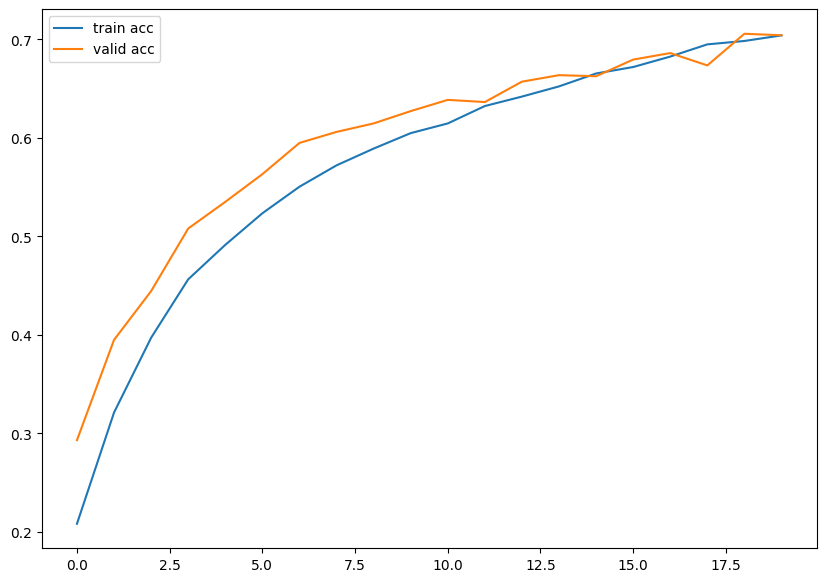

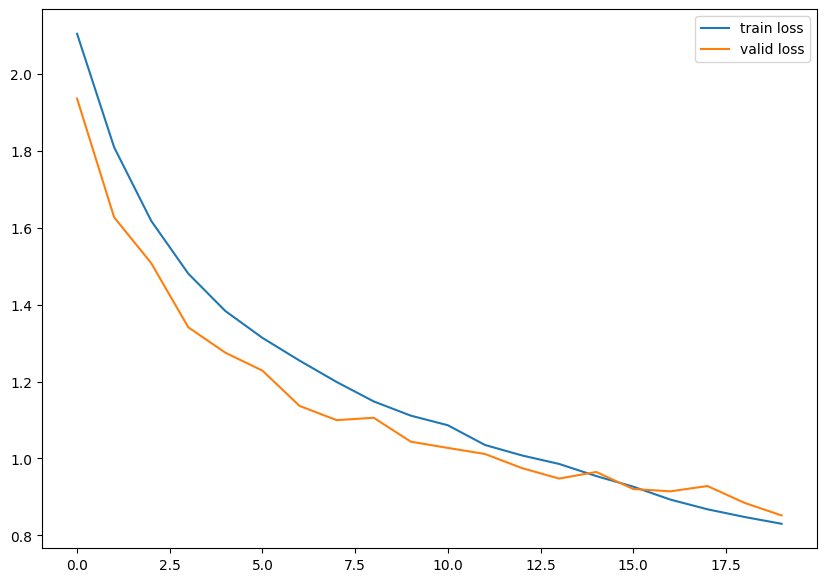

In [20]:
# accuracyとlossの推移
# accuracy
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(mean_train_accuracy, label='train acc')
ax.plot(mean_valid_accuracy, label='valid acc')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

# loss
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(mean_train_losses, label='train loss')
ax.plot(mean_valid_losses, label='valid loss')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

In [21]:
# 評価
model.eval()
test_preds = torch.LongTensor()
test_correct = 0
test_total = 0
for i, (images, labels) in enumerate(test_loader):  # ミニバッチサイズ分のデータを順に扱う
    images = images.to(device)    
    labels = labels.to(device)
    test_preds = test_preds.to(device)
    
    outputs = model(images)
    
    _, test_predicted = torch.max(outputs.data, 1)
    test_correct += (test_predicted == labels).sum().item()
    test_total += labels.size(0)
    test_preds = torch.cat((test_preds, test_predicted), dim=0)

print('test acc : {:.2f}%'.format(100*test_correct/test_total))

test acc : 69.46%


In [22]:
# モデルの評価
model.eval()

test_preds = torch.LongTensor()
test_correct = 0
test_total = 0
misclassified = {i: 0 for i in range(10)}

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)    
        labels = labels.to(device)
        test_preds = test_preds.to(device)

        outputs = model(images)

        _, test_predicted = torch.max(outputs.data, 1)
        test_correct += (test_predicted == labels).sum().item()
        test_total += labels.size(0)
        test_preds = torch.cat((test_preds, test_predicted), dim=0)

        # 間違えたラベルの数をカウント
        for i in range(len(labels)):
            if test_predicted[i] != labels[i]:
                misclassified[labels[i].item()] += 1

print('Test Accuracy: {:.2f}%'.format(100 * test_correct / test_total))

# 間違えたラベルとその数を表示
print('Misclassified Labels:')
for label, count in misclassified.items():
    print('Label {}: {}'.format(label, count))


Test Accuracy: 69.46%
Misclassified Labels:
Label 0: 303
Label 1: 128
Label 2: 390
Label 3: 537
Label 4: 318
Label 5: 479
Label 6: 207
Label 7: 277
Label 8: 178
Label 9: 237


Test Accuracy: 69.46%


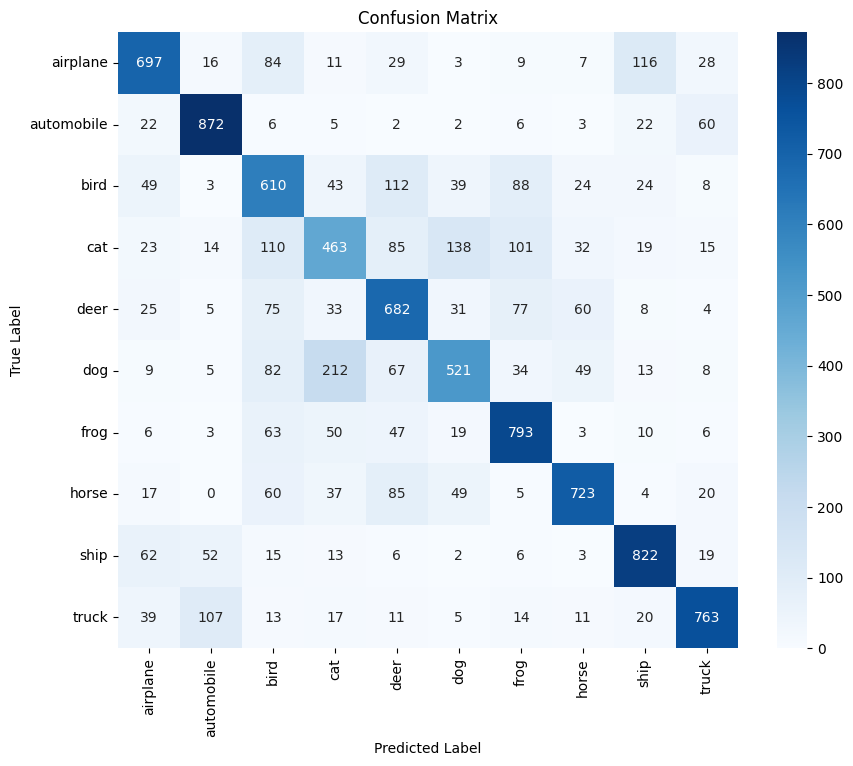

In [23]:
import numpy as np
import seaborn as sns

# モデルの評価
model.eval()

test_preds = torch.LongTensor()
test_correct = 0
test_total = 0
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
confusion_matrix = np.zeros((10, 10), dtype=int)

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)    
        labels = labels.to(device)
        test_preds = test_preds.to(device)

        outputs = model(images)

        _, test_predicted = torch.max(outputs.data, 1)
        test_correct += (test_predicted == labels).sum().item()
        test_total += labels.size(0)
        test_preds = torch.cat((test_preds, test_predicted), dim=0)

        # 混同行列を更新
        for i in range(len(labels)):
            confusion_matrix[labels[i]][test_predicted[i]] += 1

print('Test Accuracy: {:.2f}%'.format(100 * test_correct / test_total))

# 混同行列を表示
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Test Accuracy: 69.46%


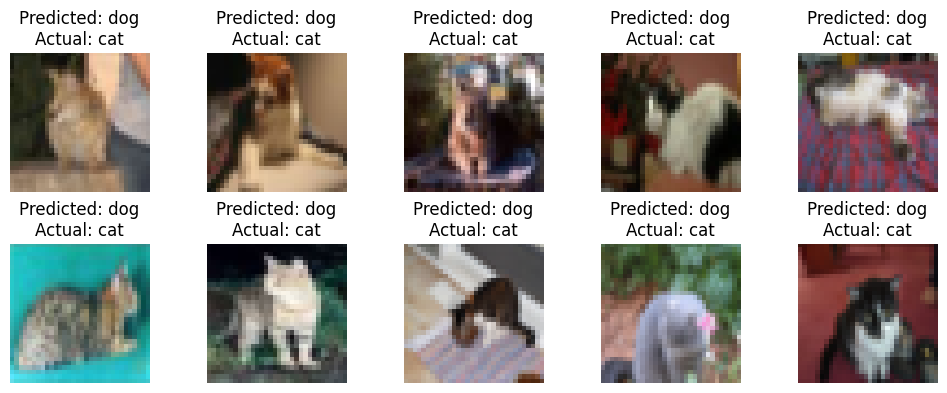

In [24]:
import matplotlib.pyplot as plt

# モデルの評価
model.eval()

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

test_preds = torch.LongTensor()
test_correct = 0
test_total = 0
misclassified_images = {i: [] for i in range(10)}
target_label = 3  # 任意の正解ラベルを指定
target_predicted_label = 5  # 任意の予測ラベルを指定
num_images_to_display = 10  # 表示する画像の枚数を指定

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)    
        labels = labels.to(device)
        test_preds = test_preds.to(device)

        outputs = model(images)

        _, test_predicted = torch.max(outputs.data, 1)
        test_correct += (test_predicted == labels).sum().item()
        test_total += labels.size(0)
        test_preds = torch.cat((test_preds, test_predicted), dim=0)

        # 間違えた画像を保存
        for i in range(len(labels)):
            if labels[i] == target_label and test_predicted[i] == target_predicted_label:
                if len(misclassified_images[labels[i].item()]) < num_images_to_display:
                    misclassified_images[labels[i].item()].append(images[i])

print('Test Accuracy: {:.2f}%'.format(100 * test_correct / test_total))

# 間違えた画像を表示
num_rows = 2  # 行数を指定
num_cols = num_images_to_display // num_rows  # 列数を計算
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 4))
for i, image in enumerate(misclassified_images[target_label]):
    row = i // num_cols  # 画像が表示される行を計算
    col = i % num_cols  # 画像が表示される列を計算
    image = image.cpu().numpy().transpose((1, 2, 0))  # チャンネル次元を最後に移動
    axes[row, col].imshow(image)
    axes[row, col].set_title('Predicted: {}\nActual: {}'.format(class_names[target_predicted_label], class_names[target_label]))
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()
